# Menyiapkan Dataset

In [1]:
import pandas as pd

/Users/gerrylorinanto/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('/Users/gerrylorinanto/Gelo/Gerry/Binar/Platinum Challenge/train_preprocess.tsv.txt', delimiter='\t')

In [4]:
df.columns = ['text','label']

In [5]:
df.head()

,text,label
0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
1,lokasi strategis di jalan sumatera bandung . t...,positive
2,betapa bahagia nya diri ini saat unboxing pake...,positive
3,duh . jadi mahasiswa jangan sombong dong . kas...,negative
4,"makanan beragam , harga makanan di food stall ...",positive


In [6]:
df.shape

(10999, 2)

In [7]:
df.isna().sum()

text     0
label    0
dtype: int64

In [8]:
df.duplicated().sum()

67

In [9]:
df = df.drop_duplicates()

# Data Preprocessing

In [12]:
df_stopword = pd.read_csv('/Users/gerrylorinanto/Gelo/Gerry/Binar/Platinum Challenge/stopwords_indonesian.csv', encoding = 'latin1')
df_alay = pd.read_csv('/Users/gerrylorinanto/Gelo/Gerry/Binar/Platinum Challenge/new_kamusalay.csv',  encoding = 'latin1')

In [13]:
df_stopword.head()

,Stopword
0,ke
1,menuturkan
2,pernah
3,cukup
4,mengucapkan


In [16]:
df_alay.head()

,anakjakartaasikasik,anak jakarta asyik asyik
0,pakcikdahtua,pak cik sudah tua
1,pakcikmudalagi,pak cik muda lagi
2,t3tapjokowi,tetap jokowi
3,3x,tiga kali
4,aamiin,amin


In [17]:
import re

In [18]:
#cleansing
def preprocess_text(text):
    #Menghapus USER,RT,URL
    text = re.sub(r'USER|\bRT\b|URL',' ',text)
    
    # lower text
    text = text.lower()
    
    #Menghapus /n
    text =  re.sub(r'\\n',' ',text)
    
    # Hapus emotikon dan karakter khusus
    text = re.sub(r'[^\w\d\s]', '', text)

    # mengganti spasi yang berlebihan
    text = re.sub(r'\s+', ' ', text)

    # Menghapus kata dan huruf yang bergabung
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Mengganti kata yang berulang
    text = re.sub(r'\b(\w+)\1\b', r'\1', text)
    return text

#removing stopwords
stopwords = df_stopword['Stopword'].tolist()
def remove_stopwords(text):
    list_stopwords = text.split()
    return ' '.join([text for text in list_stopwords if text not in stopwords])

#normalization
kamus_alay = dict(zip(df_alay['anakjakartaasikasik'], df_alay['anak jakarta asyik asyik']))
def normalize(text):
    for word in kamus_alay:
        return ' '.join([kamus_alay[word] if word in kamus_alay else word for word in text.split(' ')])


In [19]:
def cleansing_text(text):
    text = preprocess_text(text)
    text = remove_stopwords(text)
    text = normalize(text)
    
    return text

In [20]:
df['text_clean'] = df['text'].apply(cleansing_text)

In [21]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stem_text(tokens):
    return stemmer.stem(tokens)

df['text_clean'] = df['text_clean'].apply(stem_text)
df.to_csv('data_clean.csv',index = False)

In [22]:
df

,text,label,text_clean
0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus mmbri hujjah partai diwlh su...
1,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung nya nya...
2,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya unboxing paket barang nya b...
3,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning ajar...
4,"makanan beragam , harga makanan di food stall ...",positive,makan agam harga makan food stall kasir suasan...
...,...,...,...
10992,f - demokrat dorong upaya kemandirian energi n...,neutral,f demokrat dorong upaya mandiri energi nasional
10993,tidak bosan,positive,bosan
10995,enak rasa masakan nya apalagi kepiting yang me...,positive,enak masakan nya kepiting senang pilih kepitin...
10997,"pagi pagi di tol pasteur sudah macet parah , b...",negative,pagi pagi tol pasteur macet parah bikin jengkel


# Sentiment Label

In [23]:
neg = df.loc[df['label'] == 'negative'].text.tolist()
neu = df.loc[df['label'] == 'neutral'].text.tolist()
pos = df.loc[df['label'] == 'positive'].text.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('Pos: %s, Neu: %s, Neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(total_data))


Pos: 6382, Neu: 1138, Neg: 3412
Total data: 10932


# Feature Extraction

In [24]:
from nltk.tokenize import word_tokenize
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('tokenizer.pickle has created!')

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [26]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

y_labels.pickle has created!


In [27]:
import pickle

Y = pd.get_dummies(df['label'])
Y = Y.values

pickle.dump(Y, open("feature.p", "wb"))

# Splitting Dataset

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Training

In [30]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from keras.models import load_model
# tf.config.run_functions_eagerly(True)

In [31]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.3))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=1, callbacks=[es])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/5
69/69 [==============================] - 8s 105ms/step - loss: 0.6925 - accuracy: 0.7161 - val_loss: 0.5281 - val_accuracy: 0.7714
Epoch 2/5
69/69 [==============================] - 7s 103ms/step - loss: 0.3748 - accuracy: 0.8525 - val_loss: 0.3470 - val_accuracy: 0.8738
Epoch 3/5
69/69 [==============================] - 8s 109ms/step - loss: 0.2158 - accuracy: 0.9289 - val_loss: 0.3649 - val_accuracy: 0.8715
Epoch 3: early stopping


# Evaluasi

In [32]:
from sklearn import metrics

In [33]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai')
print(matrix_test)

69/69 [==============================] - 1s 9ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       685
           1       0.91      0.65      0.76       221
           2       0.88      0.95      0.91      1281

    accuracy                           0.87      2187
   macro avg       0.88      0.80      0.83      2187
weighted avg       0.87      0.87      0.87      2187



# Cross Validation

In [34]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.3))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 1s 9ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       685
           1       0.90      0.75      0.81       221
           2       0.93      0.90      0.91      1281

    accuracy                           0.88      2187
   macro avg       0.88      0.85      0.86      2187
weighted avg       0.89      0.88      0.88      2187



69/69 [==============================] - 1s 8ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       685
           1       0.85      0.77      0.81       221
           2       0.92      0.92      0.92      1281

    accuracy                           0.88      2187
   macro avg       0.87      0.85      0.86      2187
weighted avg       0.88      0.88      0.88      2187



69/69 [==============================] - 1s 8ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       685
           1       0.87      0.76      0.81       221
           2       0.93      0.91      0.92      1281

    accuracy                           0.88      2187
   macro avg       0.87      0.85      0.86      2187
weighted avg       0.88      0.88      0.88      2187



69/69 [==============================] - 1s 8ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       685
           1       0.89      0.70      0.78       221
           2       0.91      0.93      0.92      1281

    accuracy                           0.89      2187
   macro avg       0.88      0.83      0.85      2187
weighted avg       0.89      0.89      0.88      2187



69/69 [==============================] - 1s 8ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       685
           1       0.84      0.73      0.78       221
           2       0.94      0.91      0.92      1281

    accuracy                           0.88      2187
   macro avg       0.86      0.84      0.85      2187
weighted avg       0.88      0.88      0.88      2187




Rata-rata Accuracy:  0.8827617741197988


# Model Evaluation

In [36]:
import matplotlib.pyplot as plt

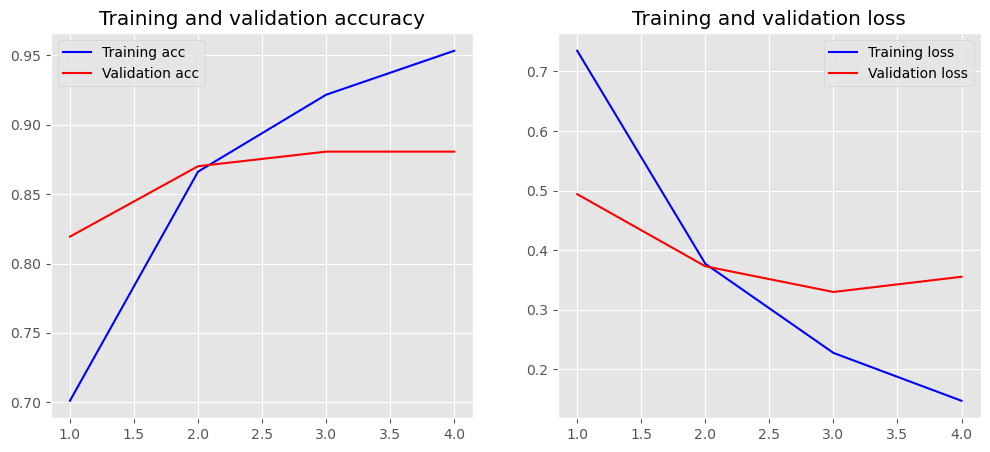

In [37]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) +1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

%matplotlib inline
plot_history(history)

In [38]:
model.save('model_lstm.h5')
print('Model has created!')

Model has created!


/Users/gerrylorinanto/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predict

In [39]:
import numpy as np

In [41]:
input_text = """
syukur cukup..,,;,;
"""

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing_text(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ',text[0])
print('Sentiment: ',sentiment[polarity])

1/1 [==============================] - 0s 128ms/step
Text:  syukur
Sentiment:  negative


In [42]:
input_text = """
SETAN..,,;,;
"""

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing_text(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ',text[0])
print('Sentiment: ',sentiment[polarity])

1/1 [==============================] - 0s 128ms/step
Text:  setan
Sentiment:  negative
